In [2]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from loaddatastructs import *
from helperfuncs import *
from plottingfuncs import *

In [35]:
matplotlib.rcParams.update({'font.size': 13})

In [4]:
Archive.archive_path = '/data/keeling/a/sf20/a/wrf-partmc-ideal-coagulation'
Archive.addScenario(scenario_name='uniform-basecase', slurm_id=1977120)
Archive.addScenario(scenario_name='fx2fy2', slurm_id=1977121)
Archive.addScenario(scenario_name='fx1fy0', slurm_id=1977122)
Archive.addScenario(scenario_name='point-source-10x10', slurm_id=1977123)
Archive.addScenario(scenario_name='point-source-1x1', slurm_id=1977124)
Archive.addScenario(scenario_name='road-10x', slurm_id=1981197)

In [5]:
def computeNumConcDiff(scenario, region):
    num_conc = Archive.aero_data[scenario]['TOT_NUM_CONC']

    if region=='lower BL':
        idx_range = np.arange(0,25)
    if region=='above BL':
        idx_range = np.arange(75,100)
    num_conc_avg = num_conc[:, idx_range, :, :].mean(axis=(2,3))
    num_conc_t0 = num_conc_avg[0, :]
    num_conc_diff = num_conc_avg/ num_conc_t0
    return num_conc_diff

In [212]:
def plotTauCoag(scenario, **kwargs):
    
    colors = plt.cm.Set1(np.linspace(0, 1, 9))
    fig, ax = plt.subplots(1,1, figsize=(8, 5.5))

    c=colors[0]
    num_conc_diff = computeNumConcDiff(scenario, region='lower BL')
    for i in np.arange(0, 25):
        label=None
        if i == 0:
            label='Lower BL'
        ax.plot(num_conc_diff[:, i], alpha=.3, c=c,lw=1,label=label)
    c=colors[1]
    num_conc_diff = computeNumConcDiff(scenario, region='above BL')
    for i in np.arange(0, 25):
        label=None
        if i == 0:
            label='Above BL'
        ax.plot(num_conc_diff[:, i], alpha=.5, c=c,lw=1,label=label)


    ax.axhline(1/(np.e), c='k', ls='--')
    ax.axhline(1/(np.sqrt(np.e)), c='k', ls='--')
    ax.axhline(1/(np.e**2), c='k', ls='--')
    ax.set_ylim(0.0, 1)
    ax.set_xlim(0, 36)
    ax.grid()

    ax.text(38, 1/np.sqrt(np.e), '$e^{-1/2}$', fontsize=18, horizontalalignment='center',
        verticalalignment='center',)
    ax.text(38, 1/np.e, '$e^{-1}$', fontsize=18, horizontalalignment='center',
        verticalalignment='center')
    ax.text(38, 1/np.e**2, '$e^{-2}$', fontsize=18, horizontalalignment='center',
        verticalalignment='center')
    
    ax.set_xticks(np.linspace(0, Archive.n_times-1, 7))
    ax.set_xticklabels(Archive.historydelta_m*np.linspace(0, Archive.n_times-1, 7))
    ax.set_xlabel('Time (m)')
    leg = ax.legend()

    for line in leg.get_lines():
        line.set_linewidth(2)
        line.set_alpha(1) 
    
    if kwargs.get('yscale'):
        ax.set_yscale(kwargs.get('yscale'))
    if kwargs.get('ylim'):
        ax.set_ylim(kwargs.get('ylim'))
    if kwargs.get('xscale'):
        ax.set_xscale(kwargs.get('xscale'))
    if kwargs.get('xlim'):
        ax.set_xlim(kwargs.get('xlim'))


    scenarios = Archive.getScenarioList()
    scenarios.insert(3, 'road-10x') # order by sh
    del scenarios[-1]

    scenario_idx = scenarios.index(scenario)
    plt.savefig(f'./figures/NumConcTimescale_scenario-{scenario_idx}.pdf', format='pdf', bbox_inches='tight')

def plotSHPattern(ax, scenario, gridsize):
    path = f'/data/keeling/a/sf20/b/wrf-partmc-spatial-het/WRFV3/test/em_les/spatial-het/sh-patterns/xres{gridsize}yres{gridsize}'

    ax.set_xticks([])
    ax.set_yticks([])
    filename = f'{scenario}.csv'
    array_path = os.path.join(path, filename)
    cmap = plt.cm.get_cmap('Greys')

    scenario_arr = np.genfromtxt(array_path, delimiter=',')
    scenario_arr = scenario_arr
    ax.pcolormesh(scenario_arr, cmap=cmap, vmin=-.3, vmax=1.3)

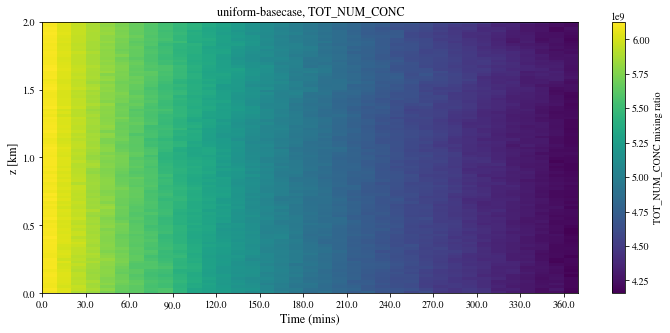

In [3]:
plotZT(scenario='uniform-basecase', variable='TOT_NUM_CONC')

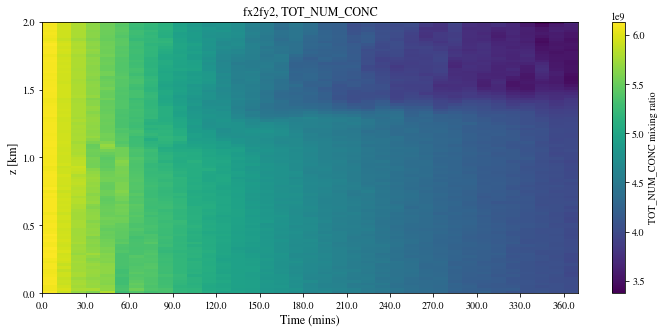

In [5]:
plotZT(scenario='fx2fy2', variable='TOT_NUM_CONC')

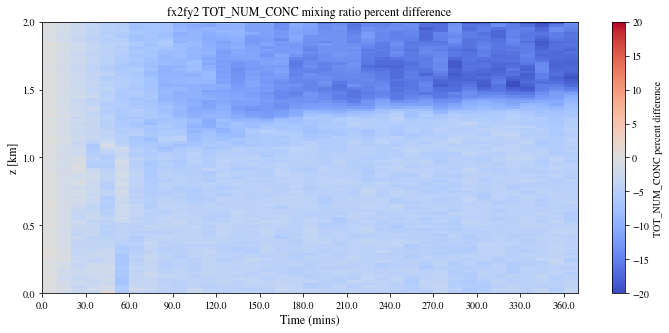

In [6]:
plotVarPercentDiff(scenario='fx2fy2', variable='TOT_NUM_CONC', title='Total Number Concentration ()'
                   mixingratio=True, vmin=-20, vmax=20)

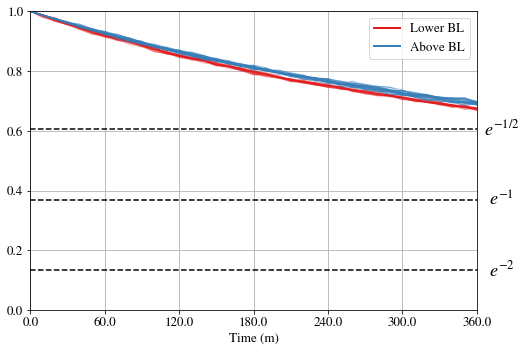

In [213]:
plotTauCoag('uniform-basecase')

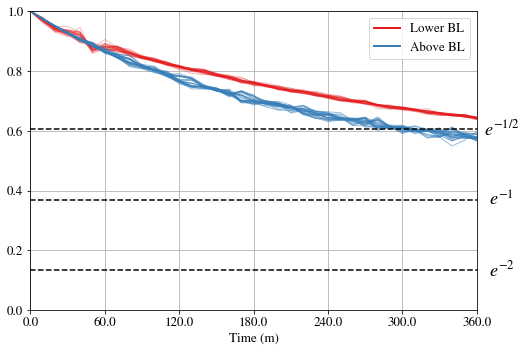

In [214]:
plotTauCoag('fx2fy2')

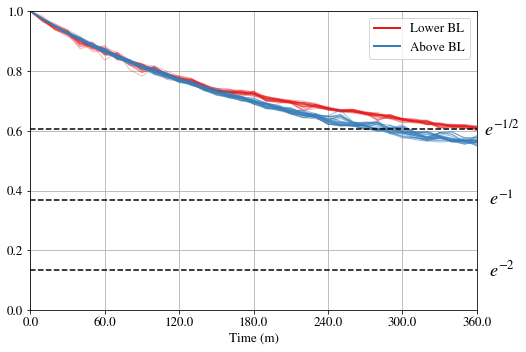

In [215]:
plotTauCoag('fx1fy0')

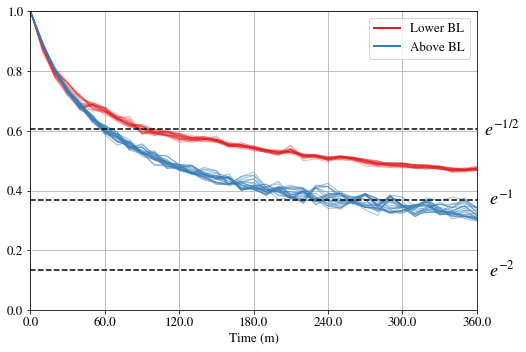

In [216]:
plotTauCoag('road-10x')

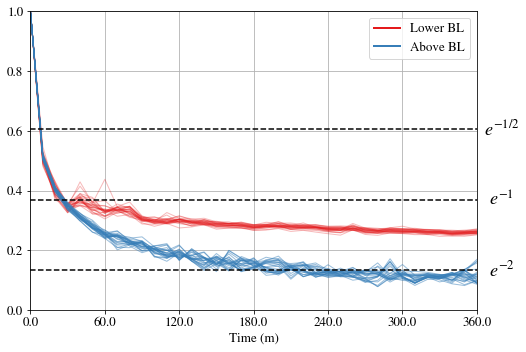

In [217]:
plotTauCoag('point-source-10x10')

Turbulence is probably responsible for reducing the rate of coagulation in the boundary layer, as it will tend to reduce local concentration gradients. Above the BL, the air is much more calm and so the local hotspot specified by the initial condition is probably better preserved through the duration of the simulation.

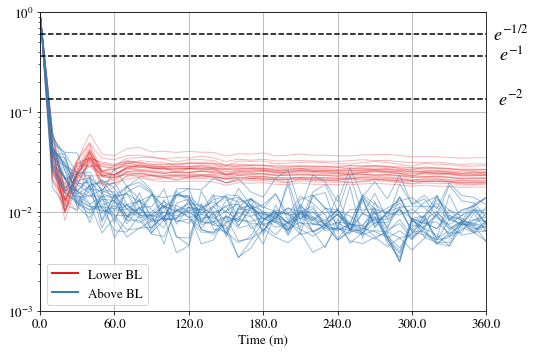

In [218]:
plotTauCoag('point-source-1x1', yscale='log', ylim=(1e-3, 1))

A log-log regression seems to work best for scenarios with high spatial heterogeneity, the power-law regression is more suitable for lower SH cases

Compute best fit from log-log regression: $\hat{Y} = \exp\left({m*\ln(X) + b}\right)$

In [43]:

from scipy.stats import linregress

def computeLogLogRegress(numconcdiff):
    
    X = np.arange(10, 361, 10)
    log_X = np.log(X)
    log_Y = np.log(numconcdiff)[1:]

    slope, intercept, r, p, se = linregress(log_X, log_Y)

    #print('Slope: \n', slope)
    #print('Intercept: \n', intercept)
    #print('Rsqr: \n',r**2)

    return slope, intercept

In [77]:
extrap_to_t = 960
np.linspace(0, extrap_to_t, int(extrap_to_t/60)+1)[::2]
tick_labels = (1/60)*np.linspace(0, extrap_to_t, int(extrap_to_t/60)+1)[::2]

In [79]:
tick_labels.astype(int)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16])

In [175]:
def plotLogLogRegress(scenario, region, **kwargs):
    extrap_to_t = 720
    numconcdiff = computeNumConcDiff(scenario, region=region).mean(axis=1).data
    slope, intercept = computeLogLogRegress(numconcdiff)
    #best_fit = np.exp(slope*np.log(np.arange(1, 361, 10)) + intercept)

    X_extend = np.arange(1, extrap_to_t+1, 10)
    best_fit_extrap = np.exp(slope*np.log(X_extend) + intercept)

    if not kwargs.get('ax'):
        fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
    else:
        ax = kwargs.get('ax')
    ax.plot(np.arange(0, 361, 10), numconcdiff, label='data', lw=2.2)
    #plt.plot(np.arange(1, 361, 10), best_fit)
    ax.plot(X_extend, best_fit_extrap, label='log-log regression', ls='--', lw=2.2)
    #plt.yscale('log')
    #ax.grid()
    #ax.legend()
    ax.set_ylim(0, 1)
    ax.set_xlim(0, extrap_to_t)
    ax.axhline(1/(np.e), c='k', ls=':')
    ax.axhline(1/(np.sqrt(np.e)), c='k', ls=':')
    ax.axhline(1/(np.e**2), c='k', ls=':')


    ax.set_xticks(np.linspace(0, extrap_to_t, int(extrap_to_t/60)+1)[::4])
    tick_labels = (1/60)*np.linspace(0, extrap_to_t, int(extrap_to_t/60)+1)[::4]
    ax.set_xticklabels(tick_labels.astype(int))
    ax.set_xlabel('Time (h)')

    

    final_ax = kwargs.get('final_ax', True)
    if final_ax:
        x_loc = (7/6)*extrap_to_t
        ax.text(x_loc, 1/np.sqrt(np.e), '$e^{-1/2}$', fontsize=16, horizontalalignment='center',
            verticalalignment='center',)
        ax.text(x_loc, 1/np.e, '$e^{-1}$', fontsize=16, horizontalalignment='center',
            verticalalignment='center')
        ax.text(x_loc, 1/np.e**2, '$e^{-2}$', fontsize=16, horizontalalignment='center',
            verticalalignment='center')
        
    scenarios = Archive.getScenarioList()
    scenarios.insert(3, 'road-10x') # order by sh
    del scenarios[-1]
    ax.set_title(f'Scenario {scenarios.index(scenario)}')
    plt.tight_layout()

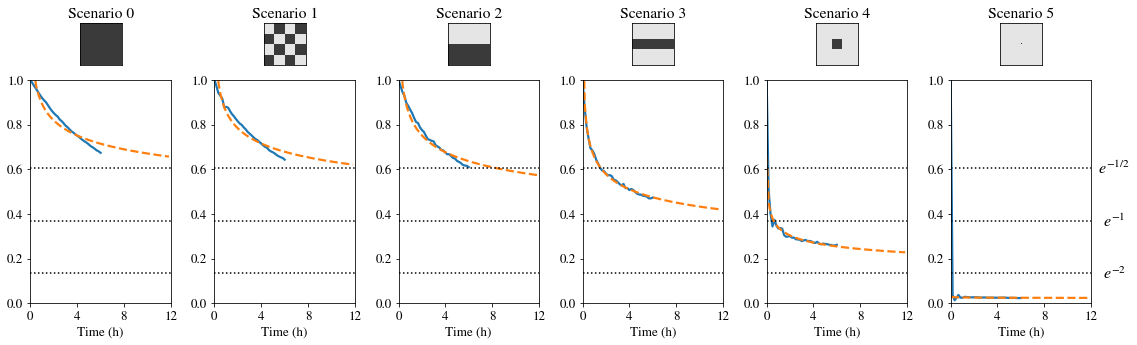

In [176]:
scenarios = Archive.getScenarioList()
scenarios.insert(3, 'road-10x') # order by sh
del scenarios[-1]
fig, ax = plt.subplots(1, len(scenarios), figsize=(16, 5))
for i, scenario in enumerate(scenarios):
    final_ax = True
    if i != len(scenarios)-1:
        final_ax = False
    
    plotLogLogRegress(scenario, region='lower BL', ax=ax[i], final_ax=final_ax)

    
    width = .3
    axin = ax[i].inset_axes([.5-.5*width, 1.01, width, width])
    axin.set_aspect('equal')
    plotSHPattern(axin, scenario, gridsize=40) # using 40 instead of 100 because the 1x1 case is so small its not drawn at 100 res
plt.savefig(f'./figures/NumConcLogLogFit_AllScenarios.pdf', format='pdf', bbox_inches='tight')


Power law regression: $\hat{Y} = a + bX^m$

In [177]:
from scipy.optimize import curve_fit

def func(X, m, b, a):
    return b*X**m + a

def computePowerRegress(func, numconcdiff):

    X = np.arange(0, 361, 10)
    Y = numconcdiff
    coeff, var = curve_fit(func, X, Y)
    return coeff, var

def plotPowerRegress(scenario, region, **kwargs):
    extrap_to_t = 720
    numconcdiff = computeNumConcDiff(scenario, region=region).mean(axis=1).data
    coeff, var = computePowerRegress(func, numconcdiff)
    X = np.arange(0, 361, 10)
    X_extend = np.arange(1, extrap_to_t+1, 10)

    #Y_pred = func(X, coeff[0], coeff[1], coeff[2])
    Y_pred_extend = func(X_extend, coeff[0], coeff[1], coeff[2])

    if not kwargs.get('ax'):
        fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
    else:
        ax = kwargs.get('ax')

    ax.plot(X, numconcdiff, label='data', lw=2.2)

    #plt.plot(X, Y_pred, label='Power law regression')
    ax.plot(X_extend, Y_pred_extend, label='Power law regression', lw=2.2, ls='--')

    #ax.grid()
    #ax.legend()
    ax.set_ylim(0, 1)
    ax.set_xlim(0, extrap_to_t)
    ax.axhline(1/(np.e), c='k', ls=':')
    ax.axhline(1/(np.sqrt(np.e)), c='k', ls=':')
    ax.axhline(1/(np.e**2), c='k', ls=':')

    ax.set_xticks(np.linspace(0, extrap_to_t, int(extrap_to_t/60)+1)[::4])
    tick_labels = (1/60)*np.linspace(0, extrap_to_t, int(extrap_to_t/60)+1)[::4]
    ax.set_xticklabels(tick_labels.astype(int))
    ax.set_xlabel('Time (h)')



    final_ax = kwargs.get('final_ax', True)
    if final_ax:
        x_loc = (7/6)*extrap_to_t
        ax.text(x_loc, 1/np.sqrt(np.e), '$e^{-1/2}$', fontsize=16, horizontalalignment='center',
            verticalalignment='center',)
        ax.text(x_loc, 1/np.e, '$e^{-1}$', fontsize=16, horizontalalignment='center',
            verticalalignment='center')
        ax.text(x_loc, 1/np.e**2, '$e^{-2}$', fontsize=16, horizontalalignment='center',
            verticalalignment='center')
    scenarios = Archive.getScenarioList()
    scenarios.insert(3, 'road-10x') # order by sh
    del scenarios[-1]
    ax.set_title(f'Scenario {scenarios.index(scenario)}')
    plt.tight_layout()

/tmp/ipykernel_227903/557510263.py:4: RuntimeWarning: divide by zero encountered in power
  return b*X**m + a
/tmp/ipykernel_227903/557510263.py:4: RuntimeWarning: divide by zero encountered in power
  return b*X**m + a


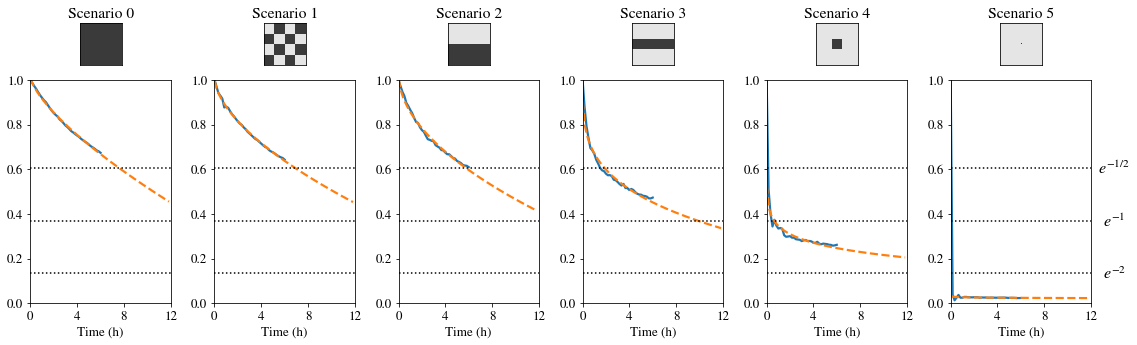

In [178]:
scenarios = Archive.getScenarioList()
scenarios.insert(3, 'road-10x') # order by sh
del scenarios[-1]
fig, ax = plt.subplots(1, len(scenarios), figsize=(16, 5))
for i, scenario in enumerate(scenarios):
    final_ax = True
    if i != len(scenarios)-1:
        final_ax = False
    
    plotPowerRegress(scenario, region='lower BL', ax=ax[i],final_ax=final_ax)

    width = .3
    axin = ax[i].inset_axes([.5-.5*width, 1.01, width, width])
    axin.set_aspect('equal')
    plotSHPattern(axin, scenario, gridsize=40) # using 40 instead of 100 because the 1x1 case is so small its not drawn at 100 res

plt.savefig(f'./figures/NumConcPowerFit_AllScenarios.pdf', format='pdf', bbox_inches='tight')


Use the analytic expression in Seinfeld and Pandis (pg 554) for number concentration expression: $N(t) = \frac{N_0}{1 + (t/\tau_c)}$. Since everything is normalized the denominator here is just 1.

In [160]:
from scipy.optimize import curve_fit

def func(X, m):
    return 1/(1+X/m)

def computeCurveRegress(func, numconcdiff):

    X = np.arange(0, 361, 10)
    Y = numconcdiff
    coeff, var = curve_fit(func, X, Y)
    return coeff, var

def plotCurveRegress(scenario, region, **kwargs):
    extrap_to_t = 720
    numconcdiff = computeNumConcDiff(scenario, region=region).mean(axis=1).data
    coeff, var = computeCurveRegress(func, numconcdiff)
    X = np.arange(0, 361, 10)
    X_extend = np.arange(1, extrap_to_t+1, 10)

    Y_pred = func(X, coeff[0])
    Y_pred_extend = func(X_extend, coeff[0])

    if not kwargs.get('ax'):
        fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
    else:
        ax = kwargs.get('ax')

    ax.plot(X, numconcdiff, label='data', lw=2.2)

    #plt.plot(X, Y_pred, label='Power law regression')
    ax.plot(X_extend, Y_pred_extend, label='regression', lw=2.2, ls='--')

    #ax.grid()
    #ax.legend()
    ax.set_ylim(0, 1)
    ax.set_xlim(0, extrap_to_t)
    ax.axhline(1/(np.e), c='k', ls=':')
    ax.axhline(1/(np.sqrt(np.e)), c='k', ls=':')
    ax.axhline(1/(np.e**2), c='k', ls=':')
    
    ax.set_xticks(np.linspace(0, extrap_to_t, int(extrap_to_t/60)+1)[::4])
    tick_labels = (1/60)*np.linspace(0, extrap_to_t, int(extrap_to_t/60)+1)[::4]
    ax.set_xticklabels(tick_labels.astype(int))
    ax.set_xlabel('Time (h)')



    final_ax = kwargs.get('final_ax', True)
    if final_ax:
        x_loc = (7/6)*extrap_to_t
        ax.text(x_loc, 1/np.sqrt(np.e), '$e^{-1/2}$', fontsize=16, horizontalalignment='center',
            verticalalignment='center',)
        ax.text(x_loc, 1/np.e, '$e^{-1}$', fontsize=16, horizontalalignment='center',
            verticalalignment='center')
        ax.text(x_loc, 1/np.e**2, '$e^{-2}$', fontsize=16, horizontalalignment='center',
            verticalalignment='center')
    #ax.set_title(f'{scenario}')
    plt.tight_layout()


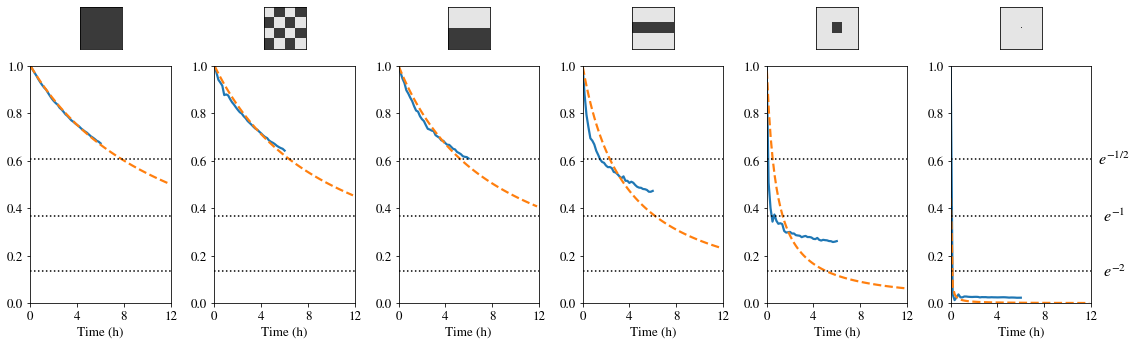

In [161]:
scenarios = Archive.getScenarioList()
scenarios.insert(3, 'road-10x') # order by sh
del scenarios[-1]
fig, ax = plt.subplots(1, len(scenarios), figsize=(16, 5))
for i, scenario in enumerate(scenarios):
    final_ax = True
    if i != len(scenarios)-1:
        final_ax = False
    plotCurveRegress(scenario, region='lower BL', ax=ax[i], final_ax=final_ax)

    width = .3
    axin = ax[i].inset_axes([.5-.5*width, 1.01, width, width])
    axin.set_aspect('equal')
    plotSHPattern(axin, scenario, gridsize=40) # using 40 instead of 100 because the 1x1 case is so small its not drawn at 100 res

Time to 75% vs. SH

In [206]:
scenario_sh, scaling_sh = Archive.getScenarioSH(gridsize=100, return_scaling=True)
scenarios = Archive.getScenarioList()

dataset = pd.DataFrame(columns=['scenario', 'sh', 'scaling', 't_quarter_reduct'])
for i, scenario in enumerate(scenarios):
    sh = scenario_sh[scenario]
    scaling = scaling_sh[scenario]
    region = 'lower BL'
    numconcdiff = computeNumConcDiff(scenario, region=region).mean(axis=1).data
    # time at which the number conc reaches 75% of its original value
    t_quarter_reduct = Archive.historydelta_m*np.where(numconcdiff <= 0.75)[0][0]

    dataset.loc[i, 'scenario'] = scenario
    dataset.loc[i, 'sh'] = sh
    dataset.loc[i, 'scaling'] = scaling
    dataset.loc[i, 't_quarter_reduct'] = t_quarter_reduct

0.0

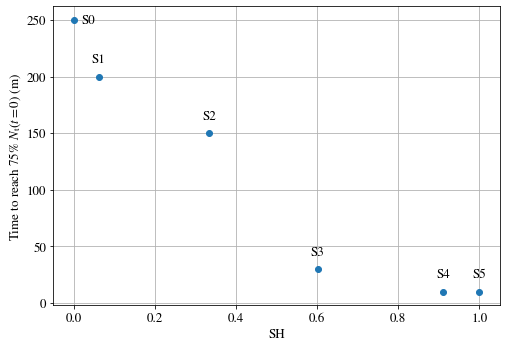

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
ax.set_axisbelow(True)
ax.grid()
ax.scatter(dataset.sh, dataset.t_quarter_reduct)

scenarios = Archive.getScenarioList()
scenarios.insert(3, 'road-10x') # order by sh
del scenarios[-1]

# Add scenario labels to points
for i, scenario in enumerate(scenarios):
    sh = dataset[dataset.scenario==scenario].sh.values[0]
    t_quarter_reduct = dataset[dataset.scenario==scenario].t_quarter_reduct.values[0]
    scenario_idx = scenarios.index(scenario)
    ha = 'center'
    va = 'bottom'
    vert_displace = 10
    horiz_displace = 0
    scenario = f'S{scenario_idx}'
    if scenario == 'S0':
        ha='left'
        va = 'center'
        vert_displace = 0
        horiz_displace = .02
    ax.annotate(scenario, (sh+horiz_displace, t_quarter_reduct+vert_displace), horizontalalignment=ha, verticalalignment=va)


ax.set_xlabel('SH')
ax.set_ylabel('Time to reach $75\%$ $N_{\mathrm{t}}(t=0)$ (m)')
plt.savefig(f'./figures/TimeTo75pcnt_vs_SH.pdf', format='pdf', bbox_inches='tight')


Text(0, 0.5, 'Time to reach $75\\%$ $N_{\\mathrm{t}}(t=0)$ (m)')

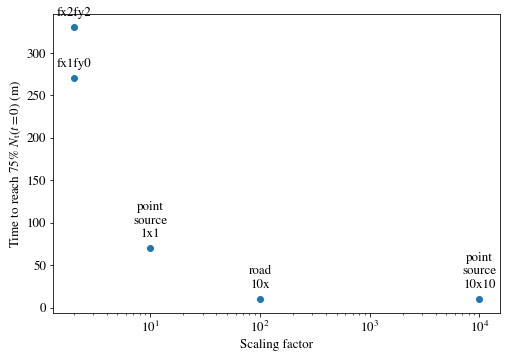

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
ax.scatter(dataset.scaling, dataset.t_quarter_reduct)

# Add scenario labels to points
for i, scenario in enumerate(scenarios):
    ha = 'center'
    va = 'bottom'
    vert_displace = 10
    horiz_displace = 0
    if scenario == 'uniform-basecase':
        ha='left'
        va = 'center'
        vert_displace = 0
        horiz_displace = .3
    scenario = scenario.replace('-', '\n')
    ax.annotate(scenario, (dataset.scaling[i]+horiz_displace, dataset.t_quarter_reduct[i]+vert_displace), horizontalalignment=ha, verticalalignment=va)

ax.set_xscale('log')
ax.set_xlabel('Scaling factor')
ax.set_ylabel('Time to reach $75\%$ $N_{\mathrm{t}}(t=0)$ (m)')

Time to 66% vs SH

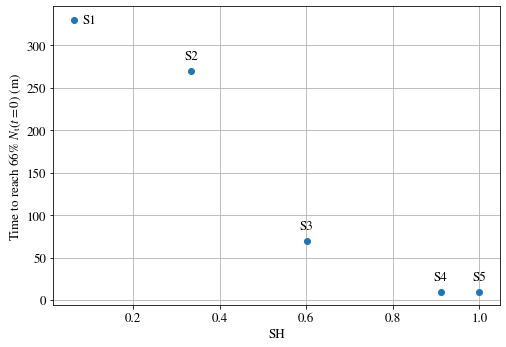

In [211]:
scenario_sh, scaling_sh = Archive.getScenarioSH(gridsize=100, return_scaling=True)
scenarios = Archive.getScenarioList()

dataset = pd.DataFrame(columns=['scenario', 'sh', 'scaling', 't_quarter_reduct'])
for i, scenario in enumerate(scenarios):
    sh = scenario_sh[scenario]
    scaling = scaling_sh[scenario]
    region = 'lower BL'
    numconcdiff = computeNumConcDiff(scenario, region=region).mean(axis=1).data
    # time at which the number conc reaches 75% of its original value
    try:
        t_quarter_reduct = Archive.historydelta_m*np.where(numconcdiff <= 0.66)[0][0]
    except IndexError:
        t_quarter_reduct = np.nan

    dataset.loc[i, 'scenario'] = scenario
    dataset.loc[i, 'sh'] = sh
    dataset.loc[i, 'scaling'] = scaling
    dataset.loc[i, 't_quarter_reduct'] = t_quarter_reduct

fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
ax.set_axisbelow(True)
ax.grid()
ax.scatter(dataset.sh, dataset.t_quarter_reduct)

scenarios = Archive.getScenarioList()
scenarios.insert(3, 'road-10x') # order by sh
del scenarios[-1]

# Add scenario labels to points
for i, scenario in enumerate(scenarios):
    sh = dataset[dataset.scenario==scenario].sh.values[0]
    t_quarter_reduct = dataset[dataset.scenario==scenario].t_quarter_reduct.values[0]
    scenario_idx = scenarios.index(scenario)
    ha = 'center'
    va = 'bottom'
    vert_displace = 10
    horiz_displace = 0
    scenario = f'S{scenario_idx}'
    if scenario == 'S1':
        ha='left'
        va = 'center'
        vert_displace = 0
        horiz_displace = .02
    ax.annotate(scenario, (sh+horiz_displace, t_quarter_reduct+vert_displace), horizontalalignment=ha, verticalalignment=va)

ax.set_xlabel('SH')
ax.set_ylabel('Time to reach $66\%$ $N_{\mathrm{t}}(t=0)$ (m)')
plt.savefig(f'./figures/TimeTo66pcnt_vs_SH.pdf', format='pdf', bbox_inches='tight')
